
# Prototipo básico — Asistente de carrito

**Objetivo:** mostrar un avance funcional y sencillo que cubra el flujo:
1) Cargar carrito → 2) Ver resumen de gasto → 3) Generar recomendaciones → 4) Actualizar catálogo.


In [1]:

# imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ruta de resultados
from pathlib import Path
RESULTADOS = Path("Resultados")
RESULTADOS.mkdir(exist_ok=True)

# catálogo mínimo 
catalogo = pd.DataFrame([
    # id, nombre, categoria, precio_unitario, es_basico
    (1, "Leche 1L", "basicos", 25.0, True),
    (2, "Pan de caja", "basicos", 38.0, True),
    (3, "Huevos docena", "basicos", 52.0, True),
    (4, "Refresco 2L", "caprichos", 34.0, False),
    (5, "Galletas", "caprichos", 29.0, False),
    (6, "Frijol 1kg", "regulares", 42.0, True),
    (7, "Arroz 1kg", "regulares", 36.0, True),
    (8, "Yogurt 1L", "regulares", 32.0, False),
    (9, "Agua 1.5L", "regulares", 18.0, True),
    (10, "Cereal 300g", "caprichos", 46.0, False),
], columns=["id","nombre","categoria","precio_unitario","es_basico"])

# sustituciones/duplicados simples (mismo propósito)
# clave: nombre principal; valor: lista de alternativas cercanas
sustituciones = {
    "Refresco 2L": ["Refresco 2 litros", "Refresco familiar"],
    "Agua 1.5L": ["Agua 1.5 litros", "Agua natural 1.5L"],
    "Pan de caja": ["Pan integral", "Pan blanco de caja"],
}

catalogo


,id,nombre,categoria,precio_unitario,es_basico
0,1,Leche 1L,basicos,25.0,True
1,2,Pan de caja,basicos,38.0,True
2,3,Huevos docena,basicos,52.0,True
3,4,Refresco 2L,caprichos,34.0,False
4,5,Galletas,caprichos,29.0,False
5,6,Frijol 1kg,regulares,42.0,True
6,7,Arroz 1kg,regulares,36.0,True
7,8,Yogurt 1L,regulares,32.0,False
8,9,Agua 1.5L,regulares,18.0,True
9,10,Cereal 300g,caprichos,46.0,False


In [2]:

# %%
def normaliza_nombre(s: str) -> str:
    return str(s).strip().lower()

def buscar_producto(query: str | int):
    """Devuelve la fila del catálogo por id o nombre (case-insensitive)."""
    if isinstance(query, int):
        hit = catalogo[catalogo["id"] == query]
        return hit.iloc[0] if len(hit) else None
    q = normaliza_nombre(query)
    hit = catalogo[catalogo["nombre"].str.lower() == q]
    return hit.iloc[0] if len(hit) else None

def es_sustituto(nombre_a: str, nombre_b: str) -> bool:
    a = nombre_a.strip()
    b = nombre_b.strip()
    # misma normalización
    if normaliza_nombre(a) == normaliza_nombre(b):
        return True
    # revisar en ambos sentidos en el diccionario
    if a in sustituciones and b in sustituciones[a]:
        return True
    if b in sustituciones and a in sustituciones[b]:
        return True
    # revisar si alguno aparece como alternativa de otro item
    for base, alts in sustituciones.items():
        if (a == base and b in alts) or (b == base and a in alts):
            return True
    return False



## 1) Cargar carrito
Para el prototipo, usamos un carrito de ejemplo. La estructura es: lista de dicts con `nombre` o `id` y `cantidad`.


In [3]:

# %%
carrito = [
    {"nombre": "Leche 1L", "cantidad": 2},
    {"nombre": "Pan de caja", "cantidad": 1},
    {"nombre": "Refresco 2 litros", "cantidad": 1},   # variante que mapea a 'Refresco 2L'
    {"nombre": "Galletas", "cantidad": 2},
    {"nombre": "Agua natural 1.5L", "cantidad": 3},   # variante de 'Agua 1.5L'
]

pd.DataFrame(carrito)


,nombre,cantidad
0,Leche 1L,2
1,Pan de caja,1
2,Refresco 2 litros,1
3,Galletas,2
4,Agua natural 1.5L,3



## 2) Ver resumen de gasto
Calculamos el total y la distribución por categoría. Guardamos el gráfico en *Resultados/resumen_gasto.png*.


Total: 146.0


,nombre,categoria,precio_unitario,cantidad,subtotal,es_basico
0,Leche 1L,basicos,25.0,2,50.0,True
1,Pan de caja,basicos,38.0,1,38.0,True
2,Galletas,caprichos,29.0,2,58.0,False


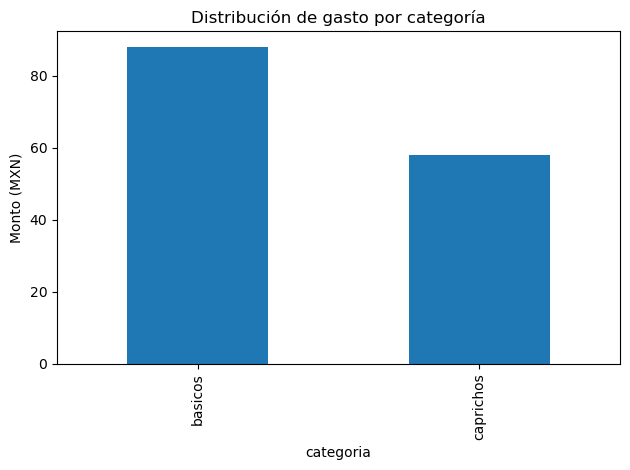

In [4]:

# %%
def resumen_gasto(carrito):
    # expandir a filas con precio y categoría
    filas = []
    for item in carrito:
        prod = buscar_producto(item.get("id") if "id" in item else item.get("nombre"))
        if prod is None:
            continue
        filas.append({
            "nombre": prod["nombre"],
            "categoria": prod["categoria"],
            "precio_unitario": float(prod["precio_unitario"]),
            "cantidad": int(item["cantidad"]),
            "subtotal": float(prod["precio_unitario"]) * int(item["cantidad"]),
            "es_basico": bool(prod["es_basico"]),
        })
    df = pd.DataFrame(filas)
    total = df["subtotal"].sum() if not df.empty else 0.0
    por_categoria = df.groupby("categoria")["subtotal"].sum().sort_values(ascending=False)
    return df, total, por_categoria

df_carrito, total, por_cat = resumen_gasto(carrito)
print("Total:", round(total, 2))
display(df_carrito)

# gráfico simple
plt.figure()
por_cat.plot(kind="bar")
plt.title("Distribución de gasto por categoría")
plt.ylabel("Monto (MXN)")
plt.tight_layout()
plt.savefig(RESULTADOS / "resumen_gasto.png", dpi=160)
plt.show()



## 3) Generar recomendaciones (reglas simples)
Reglas incluidas en el prototipo:
- Detectar **duplicados/sustitutos** y sugerir dejar una sola presentación.
- Sugerir **básicos faltantes** comunes si no aparecen (leche, pan, huevos, arroz, frijol, agua).
- Advertir si el gasto en **caprichos** excede el 30% del total.


In [5]:

# %%
BASICOS_COMUNES = ["Leche 1L", "Pan de caja", "Huevos docena", "Arroz 1kg", "Frijol 1kg", "Agua 1.5L"]

def generar_recomendaciones(carrito):
    recomendaciones = []
    # 1) duplicados/sustitutos
    nombres = [buscar_producto(it.get("id") if "id" in it else it["nombre"])["nombre"]
               for it in carrito if buscar_producto(it.get("id") if "id" in it else it.get("nombre")) is not None]
    revisados = set()
    for i, a in enumerate(nombres):
        if a in revisados: 
            continue
        grupo = [a]
        for b in nombres[i+1:]:
            if es_sustituto(a, b):
                grupo.append(b)
        if len(grupo) > 1:
            recomendaciones.append(f"Considera dejar solo una presentación entre: {', '.join(sorted(set(grupo)))}.")
        revisados.update(grupo)

    # 2) básicos faltantes
    presentes = set(nombres)
    faltantes = []
    for b in BASICOS_COMUNES:
        prod = buscar_producto(b)
        if prod is None:
            continue
        # buscar equivalentes por sustitución
        tiene_equivalente = any(es_sustituto(b, x) for x in presentes)
        if (prod["nombre"] not in presentes) and (not tiene_equivalente):
            faltantes.append(prod["nombre"])
    if faltantes:
        recomendaciones.append("Faltan básicos recomendados: " + ", ".join(faltantes) + ".")

    # 3) proporción caprichos
    df, total, por_cat = resumen_gasto(carrito)
    if total > 0:
        gasto_caprichos = float(df[df["categoria"]=="caprichos"]["subtotal"].sum())
        if gasto_caprichos / total > 0.30:
            recomendaciones.append("Tu gasto en caprichos supera el 30% del total. Revisa si puedes reducir alguno.")
    
    return recomendaciones

recs = generar_recomendaciones(carrito)
print("\n".join(recs) if recs else "Sin recomendaciones por ahora.")


Faltan básicos recomendados: Huevos docena, Arroz 1kg, Frijol 1kg, Agua 1.5L.
Tu gasto en caprichos supera el 30% del total. Revisa si puedes reducir alguno.



## 4) Actualizar catálogo (básico)
Funciones simples para **agregar** o **actualizar** productos y **registrar sustituciones**.


In [6]:

# %%
def agregar_producto(id:int, nombre:str, categoria:str, precio_unitario:float, es_basico:bool):
    global catalogo
    if any(catalogo["id"] == id):
        raise ValueError("Ya existe un producto con ese id.")
    nuevo = pd.DataFrame([(id, nombre, categoria, float(precio_unitario), bool(es_basico))],
                         columns=catalogo.columns)
    catalogo = pd.concat([catalogo, nuevo], ignore_index=True)

def actualizar_precio(id:int, nuevo_precio:float):
    global catalogo
    mask = catalogo["id"] == id
    if not mask.any():
        raise ValueError("Producto no encontrado.")
    catalogo.loc[mask, "precio_unitario"] = float(nuevo_precio)

def registrar_sustitucion(base:str, alternativa:str):
    base = base.strip()
    alternativa = alternativa.strip()
    if base not in sustituciones:
        sustituciones[base] = []
    if alternativa not in sustituciones[base]:
        sustituciones[base].append(alternativa)

# ejemplo mínimo de uso
agregar_producto(11, "Aceite 1L", "regulares", 55.0, True)
actualizar_precio(4, 35.5)  # cambiar precio del Refresco 2L
registrar_sustitucion("Agua 1.5L", "Agua de 1.5 litros")

catalogo.tail(3)


,id,nombre,categoria,precio_unitario,es_basico
8,9,Agua 1.5L,regulares,18.0,True
9,10,Cereal 300g,caprichos,46.0,False
10,11,Aceite 1L,regulares,55.0,True



## Demostración rápida



Total: 146.0


,nombre,categoria,precio_unitario,cantidad,subtotal,es_basico
0,Leche 1L,basicos,25.0,2,50.0,True
1,Pan de caja,basicos,38.0,1,38.0,True
2,Galletas,caprichos,29.0,2,58.0,False


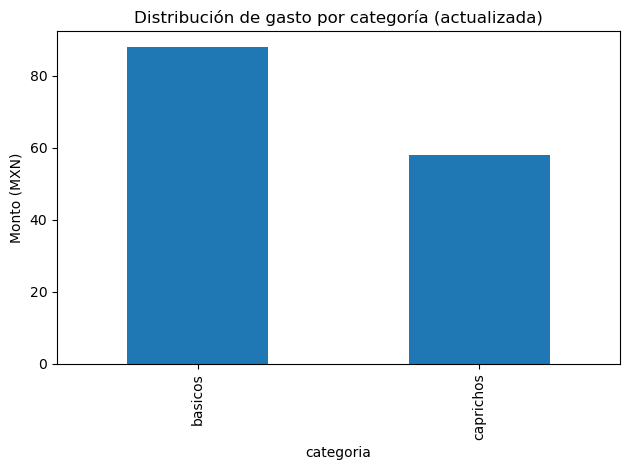

Faltan básicos recomendados: Huevos docena, Arroz 1kg, Frijol 1kg, Agua 1.5L.
Tu gasto en caprichos supera el 30% del total. Revisa si puedes reducir alguno.


In [7]:

# %%
df_carrito, total, por_cat = resumen_gasto(carrito)
print("Total:", round(total, 2))
display(df_carrito)
plt.figure()
por_cat.plot(kind="bar")
plt.title("Distribución de gasto por categoría (actualizada)")
plt.ylabel("Monto (MXN)")
plt.tight_layout()
plt.show()

recs = generar_recomendaciones(carrito)
print("\n".join(recs) if recs else "Sin recomendaciones por ahora.")
